# OpenBeer - DataLoader - Notebook  
  
### 0. Load modules

In [1]:
#Load modules and set seaborn styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
sns.set()

### I. Read Data

In [2]:
#set columns from header row of csv file and path
columns_to_load = { "beers":["id","brewery_id","name","cat_id","style_id","abv","ibu","srm","descript"],
                    "breweries":["id","name","address1","address2","city","state","code","country"], 
                    "categories":["id","cat_name"], 
                    "styles":["id","cat_id","style_name"],
                    "breweries_geocode":["id","brewery_id","latitude","longitude","accuracy"]}

dfs = {}
paths = [name for name in glob.glob("data\*.csv")]
files = [os.path.splitext(os.path.basename(name))[0] for name in glob.glob("data\*.csv")]
#read raw data for beers
for i,p in enumerate(paths):
    df_temp = pd.read_csv(p, usecols=columns_to_load[files[i]], na_values=[-1])
    dfs[files[i]] = df_temp.copy()

#explore top 5 rows if loaded correctly for each df
for f in files:
    print(f,dfs[f].info())

#assign each df to a separate variable for further exploration
df_beers_raw = dfs["beers"]
df_breweries_raw = dfs["breweries"]
df_breweries_geocode_raw = dfs["breweries_geocode"]
df_categories_raw = dfs["categories"]
df_styles_raw = dfs["styles"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5861 entries, 0 to 5860
Data columns (total 9 columns):
id            5845 non-null object
brewery_id    5837 non-null object
name          5837 non-null object
cat_id        4372 non-null object
style_id      4369 non-null object
abv           5825 non-null object
ibu           5822 non-null object
srm           5822 non-null object
descript      1972 non-null object
dtypes: object(9)
memory usage: 412.2+ KB
beers None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 8 columns):
id          1414 non-null int64
name        1414 non-null object
address1    1145 non-null object
address2    4 non-null object
city        1392 non-null object
state       1232 non-null object
code        779 non-null object
country     1413 non-null object
dtypes: int64(1), object(7)
memory usage: 88.5+ KB
breweries None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304 entries, 0 to 1303
Data columns (total 5

## Beers Cleaning and enhancement

In [3]:
#making a copy of beer from raw
df_beers = df_beers_raw.copy()

### Overview:

In [4]:
#Exploring Info, NaNs and Summary statistics

for c in df_beers.columns:
    print(df_beers[c].head())

print(df_beers.info(), "\n", df_beers.describe(), "\n", df_beers.isna().sum())

0    1
1    2
2    3
3    4
4    5
Name: id, dtype: object
0     812
1     264
2     779
3     287
4    1056
Name: brewery_id, dtype: object
0               Hocus Pocus
1         Grimbergen Blonde
2    Widdershins Barleywine
3                   Lucifer
4                    Bitter
Name: name, dtype: object
0     11
1    NaN
2    NaN
3    NaN
4    NaN
Name: cat_id, dtype: object
0    116
1    NaN
2    NaN
3    NaN
4    NaN
Name: style_id, dtype: object
0    4.5
1    6.7
2    9.1
3    8.5
4      4
Name: abv, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: ibu, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: srm, dtype: object
0    Our take on a classic summer ale.  A toast to ...
1                                                  NaN
2                                                  NaN
3                                                  NaN
4                                                  NaN
Name: descript, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

### Results:
Things to do:  
1. Change data types: ID will be replaced and still stored as objects, abv -> float, others->integers  
2. get rid of NaNs:all columns with NaNs exepted descript, cat, style will be dropped, cat + style NaNs will be extraced to be filled afterwards, descript will be stored separately  
3. exclude descript: second


In [5]:
print((df_beers.reset_index()[["id"]].applymap(lambda x: len(str(x))>4)))
list(df_beers[(df_beers.reset_index()[["id"]].applymap(lambda x: len(str(x))>4).values)].index)


id
0     False
1     False
2     False
3     False
4     False
...     ...
5856  False
5857  False
5858  False
5859  False
5860  False

[5861 rows x 1 columns]


[2637,
 3902,
 3904,
 3905,
 3906,
 3908,
 3909,
 3910,
 3912,
 4196,
 4198,
 4229,
 4231,
 4313,
 4314,
 4315,
 4403,
 4407,
 4410,
 4412,
 4416,
 4761,
 5616]

In [6]:


#drop beers without name or measurements
df_beers.dropna(subset=["name", "abv", "ibu", "srm"], axis = 0, inplace = True)

#drop nonsense rows
df_beers = df_beers.drop(list(df_beers[(df_beers.reset_index()[["id"]].applymap(lambda x: len(str(x))>4).values)].index), axis=0)

#extract NaN-rows in cat and style and save in csv
df_beers_cat_style_nan = df_beers[df_beers["cat_id"].isna() | df_beers[ "style_id"].isna()]
df_beers_cat_style_nan.to_csv("data\\temp\cat_style_nan.csv")

#extract and drop descript and save in csv
#df_beers_descript = df_beers["descript"]
#df_beers_descript.to_csv("data\\temp\\beers_descript.csv")
#df_beers = df_beers.drop("descript", axis = 1)


#drop all others beers with NaNs
df_beers.dropna(subset=[c for c in df_beers.columns if c != "descript"], axis=0, inplace=True)



In [7]:
df_beers.columns

Index(['id', 'brewery_id', 'name', 'cat_id', 'style_id', 'abv', 'ibu', 'srm',
       'descript'],
      dtype='object')

### Explore again

In [8]:

#get number of NaNs per column
print(df_beers.isna().sum())

#explore again
print(df_beers.info())
for c in df_beers.columns:
    print(df_beers[c].describe())

id               0
brewery_id       0
name             0
cat_id           0
style_id         0
abv              0
ibu              0
srm              0
descript      2537
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4361 entries, 0 to 5860
Data columns (total 9 columns):
id            4361 non-null object
brewery_id    4361 non-null object
name          4361 non-null object
cat_id        4361 non-null object
style_id      4361 non-null object
abv           4361 non-null object
ibu           4361 non-null object
srm           4361 non-null object
descript      1824 non-null object
dtypes: object(9)
memory usage: 340.7+ KB
None
count     4361
unique    4361
top       2500
freq         1
Name: id, dtype: object
count     4361
unique    1367
top       1072
freq        38
Name: brewery_id, dtype: object
count         4361
unique        3748
top       Pale Ale
freq            48
Name: name, dtype: object
count     4361.0
unique      17.0
top          3.0
freq      1248.0
Na

### Checking column per column

### 1. Name

In [9]:
#explore name
print(df_beers["name"].head())
print(df_beers["name"].describe())

0         Hocus Pocus
5       Winter Warmer
7       Oatmeal Stout
9     Chocolate Stout
12     The Kidd Lager
Name: name, dtype: object
count         4361
unique        3748
top       Pale Ale
freq            48
Name: name, dtype: object


### Interesting Observations: There are beers with the same (probably generic) names. 
***Question: What are the top 10 most used names for beers? And how often are they used in the sample? Are they really generic?***

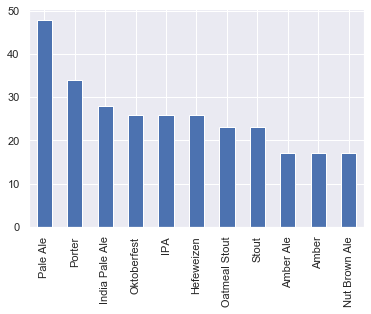

Answer: 
  The top ten names are: 

Pale Ale          48
Porter            34
India Pale Ale    28
IPA               26
Oktoberfest       26
Hefeweizen        26
Oatmeal Stout     23
Stout             23
Amber Ale         17
Nut Brown Ale     17
Name: name, dtype: int64
They are generic and used in maximum 48 times used in this sample (Pale Ale)


In [10]:
#top 10 names
#get occurance of the 10th-often beer name
occurance_10th_value = df_beers["name"].value_counts().sort_values().tail(10).head(1)

#form df with top 10 names and duplicate occurances
df_grouped_names_often = df_beers.groupby("name").filter(lambda x: len(x) > occurance_10th_value-1)

#plot top 10 names and occurances
df_grouped_names_often["name"].value_counts().plot(kind="bar")
plt.show()

print("Answer:" ,"\n"," The top ten names are:", "\n")
print(df_beers["name"].value_counts().sort_values(ascending=False).head(10))
print("They are generic and used in maximum 48 times used in this sample (Pale Ale)")

#Edit: changing the name of the column due to duplicate names with brewery
df_beers["name_beer"] = df_beers["name"]
df_beers.drop("name", axis=1, inplace=True)

### 2. Brewery_id

In [11]:
#explore brewery_id
print(df_beers["brewery_id"].head())
print(df_beers["brewery_id"].describe())

0      812
5     1385
7     1099
9      545
12     545
Name: brewery_id, dtype: object
count     4361
unique    1367
top       1072
freq        38
Name: brewery_id, dtype: object


### Observations: Some breweries have a larger variety of beers in this sample. The values are IDs only. We should enhance the dataset with names of the breweries, longitude and latitude to look who, where which beers brew the beers are brewed

***Task: merge with brewery df on brewery_id, change id to name of the brewery, concat longitude and latitude, reorder meaningful***

In [12]:
#make a copy from raw for breweries and geocodes
df_breweries = df_breweries_raw.copy()
df_breweries = df_breweries.reset_index()

#add long and lat from brewery geocodes on brewery_id to brewery table
print(df_breweries.columns)
df_breweries = pd.merge(df_breweries, df_breweries_geocode_raw, how="left", left_on = "id", right_on = "brewery_id")
df_breweries.drop("accuracy", axis=1, inplace = True)
print(df_breweries.columns)

#merge beer with brewery on brewery_id
df_beers_brewery = pd.merge(df_beers, df_breweries[["id_x", "name", "city", "country", "latitude", "longitude"]] , how="left", left_on="brewery_id" , right_on="id_x",)
df_beers_brewery["name_brewery"] = df_beers_brewery["name"]
df_beers_brewery.drop(["brewery_id","name"], axis=1, inplace=True)



#reorder columns
new_cols = ['name_beer', 'cat_id', 'style_id', 'abv', 'ibu', 'srm', 'name_brewery', 'city',
       'country', 'latitude', 'longitude', "descript"]
df_beers_brewery = df_beers_brewery[new_cols]
df_beers_brewery.head(4519).tail(1)


Index(['index', 'id', 'name', 'address1', 'address2', 'city', 'state', 'code',
       'country'],
      dtype='object')
Index(['index', 'id_x', 'name', 'address1', 'address2', 'city', 'state',
       'code', 'country', 'id_y', 'brewery_id', 'latitude', 'longitude'],
      dtype='object')


,name_beer,cat_id,style_id,abv,ibu,srm,name_brewery,city,country,latitude,longitude,descript
4374,Ambr,11,132,0,0,0,Brasserie du Bouffay,Carquefou,France,NaN,NaN,NaN


***Questions:  ***  
***1. How many different beers are brewed on average per brewery + distribution?***   
***2. Which are the top 5 most diverse breweries?***  
***3. What is the avg diversity of beers brewed per brewery per country?***  
***4. In which top 10 countries are the breweries most diverse?***

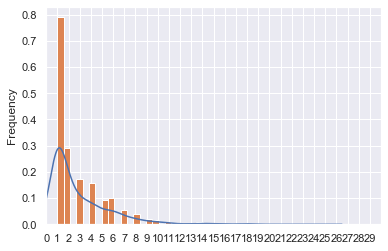

Answer 1: On average(mean) 2.87 beers are brewed per brewery 

Answer 2: The top 5 most diverse breweries are:
name_brewery
Midnight Sun Brewing Co.    18
The Livery                  18
Hoppin Frog Brewery         16
Gottberg Brew Pub           15
Abita Brewing Company       14
Name: name_beer, dtype: int64 

Answer 3: The average diversity in brewed beers per brewerie per country is: 
 country
Norway            6.000000
Argentina         4.000000
England           3.000000
Ireland           3.000000
United States     2.942478
India             2.600000
United Kingdom    2.406250
Canada            2.291667
Austria           2.200000
Russia            2.000000
Spain             2.000000
Belgium           1.968750
Switzerland       1.833333
Japan             1.666667
Germany           1.507692
Brazil            1.500000
Denmark           1.333333
Czech Republic    1.250000
Poland            1.200000
France            1.000000
Australia         1.000000
Philippines       1.000000
China   

In [13]:
#1 Group by brewery
df_grouped_brewery = df_beers_brewery.groupby("name_brewery" )
avg_beer_per_brewery = df_grouped_brewery["name_beer"].count().mean()
df_grouped_brewery["name_beer"].count().plot(kind="kde", xlim=(0, 30))
df_grouped_brewery["name_beer"].count().plot(kind="hist", density = True, bins=30)
plt.xticks(np.arange(30))
plt.show()


print("Answer 1: On average(mean) {:.2f} beers are brewed per brewery".format(avg_beer_per_brewery), "\n")

#2 used grouped_object
print("Answer 2: The top 5 most diverse breweries are:")
print(df_grouped_brewery["name_beer"].count().nlargest(5), "\n")

#3 calculate beers/country div by breweries/country
avg_div_per_country = df_beers_brewery.groupby("country")["name_beer"].nunique() / df_beers_brewery.groupby("country")["name_brewery"].nunique()
print("Answer 3: The average diversity in brewed beers per brewerie per country is:" ,"\n",avg_div_per_country.sort_values(ascending = False), "\n")
#4 get largest 10 and make comment on how many breweries are in a country
print("Answer 4: The top ten brewery-diversity countries are:","\n",avg_div_per_country.nlargest(10), "\n")
print("Comment on 4:")
for country in avg_div_per_country.nlargest(10).reset_index()["country"]:
    print(country + " has {} brewery(s)".format(df_beers_brewery.groupby("country").get_group(country)["name_brewery"].nunique()))

### 3. Cat_id

In [14]:
#Make a copy of beers with brewery for further usage (savepoint)
df_bb = df_beers_brewery.copy()

#Explore
print(df_bb["cat_id"].head())
print(df_bb["cat_id"].describe())
print(df_bb["cat_id"].value_counts())
print(df_bb["cat_id"].dtype)

0    11
1     1
2     3
3     3
4     7
Name: cat_id, dtype: object
count     4375.0
unique      17.0
top          3.0
freq      1253.0
Name: cat_id, dtype: float64
3.0     1253
3        724
8.0      319
7.0      278
8        236
1.0      186
2.0      181
5        162
5.0      161
7        155
11       151
4.0      150
1        128
11.0     114
2        105
4         68
9.0        4
Name: cat_id, dtype: int64
object


### Results:
* Its a categorical variable
* Too many unique values for categories in categories_raw
* should be replaced by values from df_categories_raw

### Tasks:
0. Clean up the column  
1. Replace IDs with values from df_categories_raw  
2. Change dtype to category

In [15]:
#drop the strange one and change dtype to int64 for merging
print(df_bb[df_bb["cat_id"]==" Weyermann Melonodon"])
df_bb.drop(df_bb[df_bb["cat_id"]==" Weyermann Melonodon"].index, axis=0, inplace=True)
df_bb["cat_id"] = df_bb["cat_id"].astype("float64")

#print value counts to ensure correct dropping
print(df_bb["cat_id"].value_counts())


#Merge with categories_raw
df_bb_cat = pd.merge(df_bb, df_categories_raw[["id","cat_name"]], how="inner", left_on= "cat_id", right_on="id")

#drop cat_id
df_bb_cat.drop("cat_id", axis=1, inplace = True)

#print head to see if everything is fine
print(df_bb_cat.head())
print(df_bb_cat["cat_name"].describe())

Empty DataFrame
Columns: [name_beer, cat_id, style_id, abv, ibu, srm, name_brewery, city, country, latitude, longitude, descript]
Index: []
3.0     1977
8.0      555
7.0      433
5.0      323
1.0      314
2.0      286
11.0     265
4.0      218
9.0        4
Name: cat_id, dtype: int64
          name_beer style_id   abv ibu srm               name_brewery  \
0       Hocus Pocus      116   4.5   0   0                  Magic Hat   
1   BiÃ¨re Darbyste      116     0   0   0      Brasserie de Blaugies   
2     Isolation Ale      141     6   0   0              Odell Brewing   
3   Nut Cracker Ale      141   5.9   0   0  Boulevard Brewing Company   
4  Never Summer Ale      141  5.94   0   0       Boulder Beer Company   

               city        country  latitude  longitude  \
0  South Burlington  United States   44.4284   -73.2131   
1          Blaugies        Belgium   50.3693     3.8270   
2      Fort Collins  United States   40.5894  -105.0630   
3       Kansas City  United States   39.0

***Questions:***  
***1. How are the categories distributed Germany?***  
***2. How is the distribution of North American Ale?***


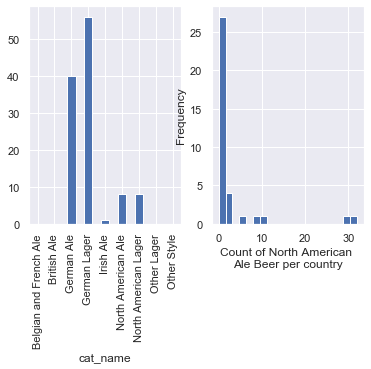

In [16]:
#Pivoting the table to show it
piv_count_cat_p_country = pd.pivot_table(df_bb_cat, values="name_beer",index="country", columns="cat_name",aggfunc="count")
piv_count_cat_p_country = piv_count_cat_p_country.fillna(0)
fig=plt.figure()

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
piv_count_cat_p_country.loc["Germany",:].plot(kind="bar", ax=ax1)
piv_count_cat_p_country[piv_count_cat_p_country["North American Ale"]<50]["North American Ale"].plot(kind="hist", bins=20, ax=ax2)
ax2.xaxis.set_label_text("Count of North American " + "\n" + "Ale Beer per country")
plt.show()

### 4. style_id

In [17]:
# create a savepoint
df_bbc = df_bb_cat.copy()

si = df_bbc["style_id"].astype("float64")

#explore 
print(si.head())
print(si.describe())
print(si.value_counts().sort_values(ascending=False))
print(si.dtype)
print(si.max())
print(si.min())
print(len(si.unique()))
print(si.isna().sum())

0    116.0
1    116.0
2    141.0
3    141.0
4    141.0
Name: style_id, dtype: float64
count    4375.000000
mean       53.003200
std        31.690194
min         1.000000
25%        26.000000
50%        42.000000
75%        84.000000
max       141.000000
Name: style_id, dtype: float64
26.0     522
95.0     503
42.0     330
33.0     297
31.0     293
        ... 
105.0      1
11.0       1
34.0       1
128.0      1
24.0       1
Name: style_id, Length: 69, dtype: int64
float64
141.0
1.0
69
0


### Results:  
* categorical variable
* should be replaced with style names from df_styles_raw

### Tasks:
1. Convert to int64
2. Replace with style names from df_styles_raw
3. clean up if necessary


In [18]:
#convert style_id to int
df_bbc["style_id"] = df_bbc["style_id"].astype("float64")
#merge dfs
df_bbcs = pd.merge(df_bbc, df_styles_raw[["id", "style_name"]], how="left", left_on="style_id", right_on="id")

#drop style_id columns
df_bbcs.drop("style_id", axis=1, inplace = True)


In [19]:
#explore again
print(df_bbcs["style_name"].describe(),
df_bbcs["style_name"].value_counts(),
df_bbcs["style_name"].unique())

count                        4375
unique                         68
top       American-Style Pale Ale
freq                          522
Name: style_name, dtype: object American-Style Pale Ale          522
American-Style Lager             503
American-Style Stout             330
American-Style Amber/Red Ale     297
American-Style India Pale Ale    293
                                ... 
Kellerbier - Ale                   1
Specialty Beer                     1
Foreign (Export)-Style Stout       1
European Low-Alcohol Lager         1
Bamberg-Style Bock Rauchbier       1
Name: style_name, Length: 68, dtype: int64 ['Light American Wheat Ale or Lager' 'Winter Warmer' 'Fruit Beer'
 'American-Style Cream Ale or Lager' 'Pumpkin Beer'
 'American Rye Ale or Lager' 'Herb and Spice Beer' 'Specialty Beer'
 'Smoke Beer' 'Out of Category' 'Specialty Honey Lager or Ale' 'Old Ale'
 'Scotch Ale' 'English-Style Pale Mild Ale' 'English-Style India Pale Ale'
 'Scottish-Style Light Ale' 'Extra Special Bitte

***Questions:***  
*1. What is the most used style?*  
*2. Which brewery has the most styles in use and what style does she serve?*  
*3. In which country are the most styles in use?*

In [20]:
#1. Group by style, count and use nlargest to find -> Better: use value_count() on style_name column and get the first one
#2. group by brewery, get style columns and use nunique + nlargest to find
#3. Same as 2 but with country instead of brewery

#1. 
most_used_style = df_bbcs.groupby("style_name")["name_beer"].count().nlargest().index[0]
print("1. The most brewed beer style is: " + most_used_style, "\n")

#2.
most_style_div_brewery = df_bbcs.groupby("name_brewery")["style_name", "name_beer"].nunique()
most_style_div_brewery["avg_beers*style"] = most_style_div_brewery["name_beer"]*most_style_div_brewery["style_name"]
style_brewery_name, style_brewery_n = most_style_div_brewery["style_name"].sort_values().index[-1], most_style_div_brewery["style_name"].sort_values().tail(1).values[0]
style_brewery_spb_name, style_brewery_spb_n = most_style_div_brewery["avg_beers*style"].sort_values().index[-1], \
                                                most_style_div_brewery["avg_beers*style"].sort_values().tail(1).values[0]

print("2a. The most diverse brewery in style total is: {} with {} styles in place".format(style_brewery_name, style_brewery_n))
print("2b. The most diverse brewery in styles * # of beers is {} with {} styles({}) * beers({})".format(style_brewery_spb_name, \
                                                                                                    style_brewery_spb_n, \
                                                                                                    most_style_div_brewery.loc[style_brewery_spb_name][ "style_name"], \
                                                                                                    most_style_div_brewery.loc[style_brewery_spb_name][ "name_beer"]) , "\n")
#3.
most_style_country_name, most_style_country_n  = df_bbcs.groupby("country")["style_name"].nunique().nlargest().index[0], df_bbcs.groupby("country")["style_name"].nunique().nlargest().values[0]
style_country_grouped = df_bbcs.groupby("country")["style_name", "name_brewery"].nunique()
style_country_grouped["styles_per_brewery"] = style_country_grouped["style_name"] / style_country_grouped["name_brewery"]
style_country_mspb_name, style_country_mspb_n = style_country_grouped["styles_per_brewery"].nlargest().index[0],style_country_grouped["styles_per_brewery"].nlargest().values[0] 

print("3a. The most diverse country in style is {} with {} styles brewed in its breweries".format(most_style_country_name, most_style_country_n))
print("3b. The most diverse country in styles per brewery is {} with {} styles per brewery".format(style_country_mspb_name, style_country_mspb_n))

1. The most brewed beer style is: American-Style Pale Ale 

2a. The most diverse brewery in style total is: Midnight Sun Brewing Co. with 12 styles in place
2b. The most diverse brewery in styles * # of beers is Midnight Sun Brewing Co. with 216 styles(12) * beers(18) 

3a. The most diverse country in style is United States with 60 styles brewed in its breweries
3b. The most diverse country in styles per brewery is Norway with 6.0 styles per brewery


### 5. abv
This column describe the alcohol per volumne and is a numeric column

In [21]:
#create a savepoint
df_bb = df_bbcs.copy()


count     4375.0
unique     240.0
top          0.0
freq      1840.0
Name: abv, dtype: float64 

0        4.5
1          0
2          6
3        5.9
4       5.94
        ... 
4370     4.3
4371     4.8
4372       7
4373     5.4
4374       1
Name: abv, Length: 4375, dtype: object
general description:  
 count    4375.000000
mean        3.492281
std         3.841267
min         0.000000
25%         0.000000
50%         4.500000
75%         6.000000
max        99.990000
Name: abv, dtype: float64 

# of NaNs: 0 

Outliers: 0.01     0.0
0.99    12.0
Name: abv, dtype: float64 



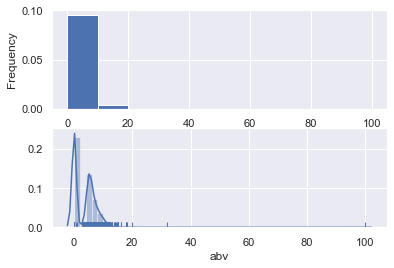

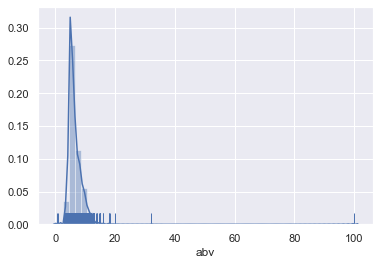

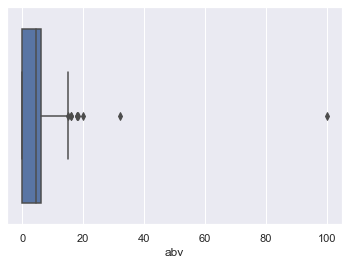

In [22]:
#simplify handling
abv = df_bb["abv"]

#explore
print(abv.describe(), "\n")
print(abv)
#change dtype to float64
abv = abv.astype("float64")

#explore again
print("general description: ","\n", abv.describe(), "\n")
print("# of NaNs: {}".format(abv.isna().sum()), "\n")
print("Outliers: {}".format(abv.quantile([0.01, .99])), "\n")


#summarize in plot to show distribution (without filter)
fig, (ax1, ax2)= plt.subplots(2, 1)
abv.plot(kind="hist", density = True, ax = ax1)
sns.distplot(abv, ax=ax2, rug= True)
plt.show()

#it seem that there are two major groups: with and without alcohol
#now plotting dist without alcohol-free beers
fig2, ax3 = plt.subplots(1,1)
sns.distplot(abv[(abv>0)], ax=ax3, rug= True)
plt.show()

#as a boxplot to identify outliers
plt.subplot()
sns.boxplot(x=abv)
plt.show()



### Results:
* column must be converted into float
* column contains no NaNs
* column could be used to distiguish between alcohol-containing and alcohol-free beer or a lot of missing values in abv
* 2 extreme outliers are identified

### Tasks:
1. Take a look at the outliers and maybe correct the values
2. convert column with corrected values to float64
3. Fill all 0s with style average

In [23]:
#taking a closer look on the 2 major outliers (roughly 100% = pure alcohol -> no beer, > 30% -> could be a very special beer)
abv_out = abv[abv>30]
print(abv_out.describe())
print(df_bb.iloc[abv_out.index, :])
norfolk_index = abv_out[abv>99].index.values[0]

#Correnting the values: Norfolk Nog Old Dark Ale = 4,6%, Tactical Nuclear Penguin is correct
df_bb.iloc[norfolk_index,1] = "4.6"
print(df_bb[df_bb["name_beer"]=="Norfolk Nog Old Dark Ale"]["abv"])
print(df_bb.iloc[norfolk_index])

count     2.00000
mean     65.99500
std      48.07619
min      32.00000
25%      48.99750
50%      65.99500
75%      82.99250
max      99.99000
Name: abv, dtype: float64
                     name_beer    abv ibu srm              name_brewery  \
347   Norfolk Nog Old Dark Ale  99.99   0   0  Woodforde's Norfolk Ales   
2464  Tactical Nuclear Penguin     32   0   0               BrewDog Ltd   

             city         country  latitude  longitude  \
347       Norwich  United Kingdom   52.6842      1.449   
2464  Fraserburgh  United Kingdom   57.6830     -2.003   

                                               descript  id_x  \
347                                                 NaN     1   
2464  This is the worlds strongest ever beer, ever (...     3   

                cat_name  id_y                     style_name  
347          British Ale    13                        Old Ale  
2464  North American Ale    43  American-Style Imperial Stout  
347    4.6
Name: abv, dtype: object
name_

In [24]:
#Converting abv column to float
df_bb["abv"] = df_bb["abv"].astype("float64")

In [25]:
#filling 0s with style average for each style

for style in df_bb["style_name"].unique():
    style_avg = df_bb[(df_bb["abv"]!=0) & (df_bb["style_name"]==style)]["abv"].mean()
    if np.isnan(style_avg):
        style_avg = 0
    print(style, " = ", style_avg )
    for  i in df_bb[(df_bb["abv"]==0) & (df_bb["style_name"]==style)].index.values:
        df_bb.set_value(i,"abv", style_avg)


Light American Wheat Ale or Lager  =  5.107575757575758
Winter Warmer  =  6.806666666666667
Fruit Beer  =  5.9051282051282055
American-Style Cream Ale or Lager  =  5.557142857142858
Pumpkin Beer  =  6.81875
American Rye Ale or Lager  =  6.540000000000001
Herb and Spice Beer  =  6.209090909090907
Specialty Beer  =  8.75
Smoke Beer  =  0
Out of Category  =  5.0
Specialty Honey Lager or Ale  =  0
Old Ale  =  8.746808510638298
Scotch Ale  =  7.239130434782608
English-Style Pale Mild Ale  =  3.6375
English-Style India Pale Ale  =  6.323636363636364
Scottish-Style Light Ale  =  4.6
Extra Special Bitter  =  5.4859375
Classic English-Style Pale Ale  =  4.964705882352941
Oatmeal Stout  =  5.83
Sweet Stout  =  6.1499999999999995
Special Bitter or Best Bitter  =  4.848
Ordinary Bitter  =  4.730769230769231
Strong Ale  =  11.25
English-Style Dark Mild Ale  =  3.2
American-Style Stout  =  6.356694915254237
American-Style India Pale Ale  =  6.543030303030303
American-Style Brown Ale  =  5.5652631578

### 6. ibu  *= International Bitterness unit:*  
    Lambic 	        0-10  
    Wheat beer 	8-18  
    American lager 	8-26  
    Kölsch 	        20-30  
    Pilsner 	24-44  
    Porter 	        18-50  
    Bitter 	        24-50  
    Pale ale 	30-50  
    Stout 	        30-90  
    Barleywine 	34-120  
    India pale ale 	40-120 

from:   https://en.wikipedia.org/wiki/Beer_measurement#Bitterness

In [26]:
df_bb.columns

Index(['name_beer', 'abv', 'ibu', 'srm', 'name_brewery', 'city', 'country',
       'latitude', 'longitude', 'descript', 'id_x', 'cat_name', 'id_y',
       'style_name'],
      dtype='object')

In [27]:
#creating a savepoint
df_bb_beforeIBU = df_bb.copy()


In [28]:
#Explore ibu
ibu = df_bb["ibu"]

print(ibu.describe())
print(ibu.value_counts())
print((ibu.value_counts()[:2]/len(ibu)).sum())

count     4375
unique      19
top          0
freq      3444
Name: ibu, dtype: int64
0       3444
0        912
30.0       2
28.0       2
65.0       1
13.0       1
19.0       1
20.0       1
21.0       1
25.0       1
31.0       1
65.5       1
93.0       1
36.0       1
38.0       1
41.0       1
50.0       1
55.0       1
35.0       1
Name: ibu, dtype: int64
0.9956571428571429


### Results: 
* Does not at value due to lack of values (~99.6% = 0)

### 7. srm  *= Standard Reference Method for measuring color of the beer*  

In [29]:
#Explore SRM

srm = df_bb["srm"]

print(srm.describe())
print(srm.value_counts())
print((srm.value_counts()[:2]/len(srm)).sum())

count     4375
unique      14
top          0
freq      3450
Name: srm, dtype: int64
0       3450
0        912
13.0       2
13.5       1
47.0       1
45.0       1
35.0       1
30.0       1
29.0       1
22.0       1
12.5       1
10.6       1
6.0        1
3.0        1
Name: srm, dtype: int64
0.9970285714285715


### Results: 
* Does not at value due to lack of values (~99.7% = 0)  
  
### Task:
* Drop ibu and srm

In [30]:
#drop ibu and srm
df_bb.drop(["ibu", "srm"], axis = 1, inplace = True)

In [31]:
#create savepoint
df_bb_wo_ibu_srm = df_bb.copy()

In [32]:
#column reminder
df_bb.columns

Index(['name_beer', 'abv', 'name_brewery', 'city', 'country', 'latitude',
       'longitude', 'descript', 'id_x', 'cat_name', 'id_y', 'style_name'],
      dtype='object')

### 8. latitude & longitude

In [33]:
#explore latitude

lat = df_bb["latitude"]
print(lat[16])
print(df_bb.info())
print(lat.describe())
print(lat.value_counts())
print(df_bb[["latitude", "longitude"]].describe())

nan
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4375 entries, 0 to 4374
Data columns (total 12 columns):
name_beer       4375 non-null object
abv             4375 non-null float64
name_brewery    1951 non-null object
city            1941 non-null object
country         1951 non-null object
latitude        1860 non-null float64
longitude       1860 non-null float64
descript        1824 non-null object
id_x            4375 non-null int64
cat_name        4375 non-null object
id_y            4375 non-null int64
style_name      4375 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 604.3+ KB
None
count    1860.000000
mean       41.766053
std         9.329660
min       -45.872000
25%        39.230800
50%        41.900950
75%        46.720800
max        61.581600
Name: latitude, dtype: float64
61.1473    18
42.1185    18
41.0247    16
41.4295    15
33.1157    14
           ..
47.4921     1
37.1875     1
50.3949     1
38.5350     1
53.0606     1
Name: latitude, Length

### Result:
* Values are good but only 40 % available

### Task:
* Exploring if lat_log NaNs correspond to city / country NaNs
* If so: Dropping all NaN-containing rows in lat, long, city, country

In [34]:
#explore potential correlation
df_bb[df_bb["latitude"].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2515 entries, 15 to 4372
Data columns (total 12 columns):
name_beer       2515 non-null object
abv             2515 non-null float64
name_brewery    91 non-null object
city            82 non-null object
country         91 non-null object
latitude        0 non-null float64
longitude       0 non-null float64
descript        1152 non-null object
id_x            2515 non-null int64
cat_name        2515 non-null object
id_y            2515 non-null int64
style_name      2515 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 255.4+ KB


In [35]:
#drop all remaining NaNs
df_bb = df_bb.dropna(subset=[c for c in df_bb.columns if c != "descript"])

#dropping id_x & id_y
df_bb = df_bb.drop(["id_x", "id_y"], axis=1)

#explore the cleaned dataframe:
print(df_bb.describe())
print(df_bb.info())

#reset index
df_bb.reset_index(drop = True, inplace=True)

abv     latitude    longitude
count  1859.000000  1859.000000  1859.000000
mean      6.330808    41.762176   -81.310898
std       1.842177     9.330671    45.781769
min       0.000000   -45.872000  -156.677000
25%       5.200000    39.230800  -117.150000
50%       5.800000    41.891500   -89.665700
75%       7.000000    46.720800   -75.220200
max      32.000000    61.581600   170.518000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859 entries, 0 to 4374
Data columns (total 10 columns):
name_beer       1859 non-null object
abv             1859 non-null float64
name_brewery    1859 non-null object
city            1859 non-null object
country         1859 non-null object
latitude        1859 non-null float64
longitude       1859 non-null float64
descript        671 non-null object
cat_name        1859 non-null object
style_name      1859 non-null object
dtypes: float64(3), object(7)
memory usage: 159.8+ KB
None


### Save the dataframe for further examination

In [36]:
df_bb.to_csv(r"data\cleaned\beer_cleaned.csv", index = False)